In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
DATAPATH = '/Users/jiehyun/Jenna/UMassBoston/Research/Nathan_Arnett_Calcification/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')


In [4]:
images = np.load(images_file)
labels = np.load(labels_file)

In [5]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [6]:
p = np.random.permutation(len(images))

In [7]:
images = images[p]
labels = labels[p]

In [8]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [9]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [10]:
images.shape

(503, 512, 512, 1)

In [11]:
X_train = images[0:300]
y_train = labels[0:300]
X_val = images[300:400]
y_val = labels[300:400]
X_test = images[400:]
y_test = labels[400:]

In [12]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=512,
                               n_labels=4, depth=4, stack_num_down=2, stack_num_up=2,
                               patch_size=(4, 4), num_heads=[4, 8, 8, 8],
                               window_size=[4, 2, 2, 2], num_mlp=512, 
                               output_activation='Softmax', shift_window=True, name='swin_unet')

In [13]:
#model = custom_unet(
#    input_shape=(512, 512, 1),
#    use_batch_norm=False,
#    num_classes=1,
#    filters=32,
#    dropout=0.5,
#    output_activation='sigmoid')

In [13]:
import keras.optimizers
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet.losses import jaccard_distance
from keras_unet_collection import losses

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=1e-3),
              metrics=['accuracy', losses.dice_coef])

/opt/homebrew/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
#model.compile(optimizer = 'Adam',    
#              loss='binary_crossentropy', 
#              #loss = losses.focal_tversky,
#              metrics=[iou, iou_thresholded, dice_coef, 'accuracy'])

In [15]:
history = model.fit(X_train, 
                    y_train, 
                    32, 
                    epochs=1,
                    validation_data=(X_val, y_val))

2023-01-20 16:43:27.973360: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


: 

: 

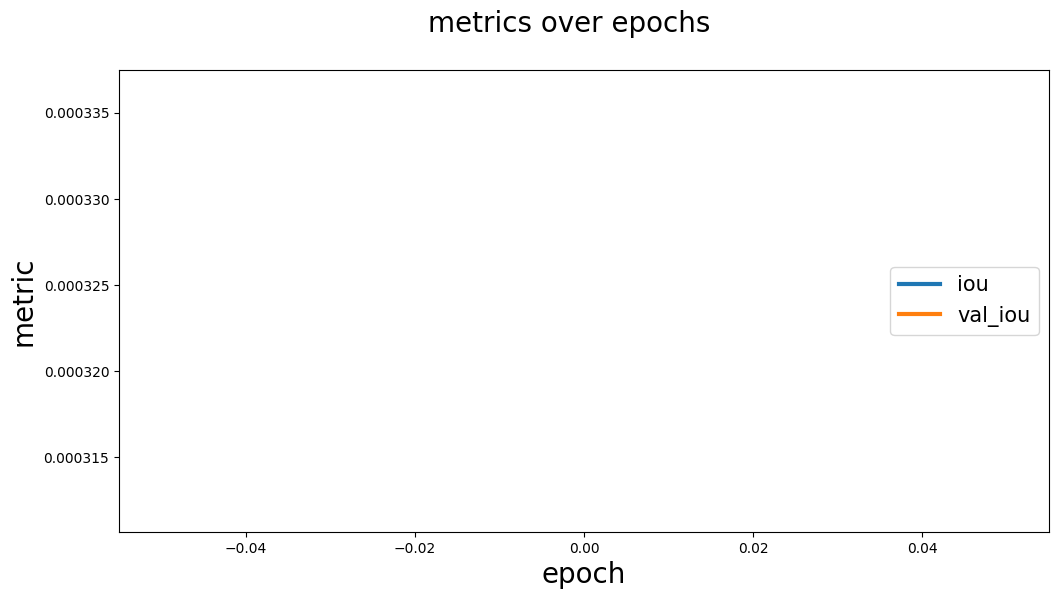

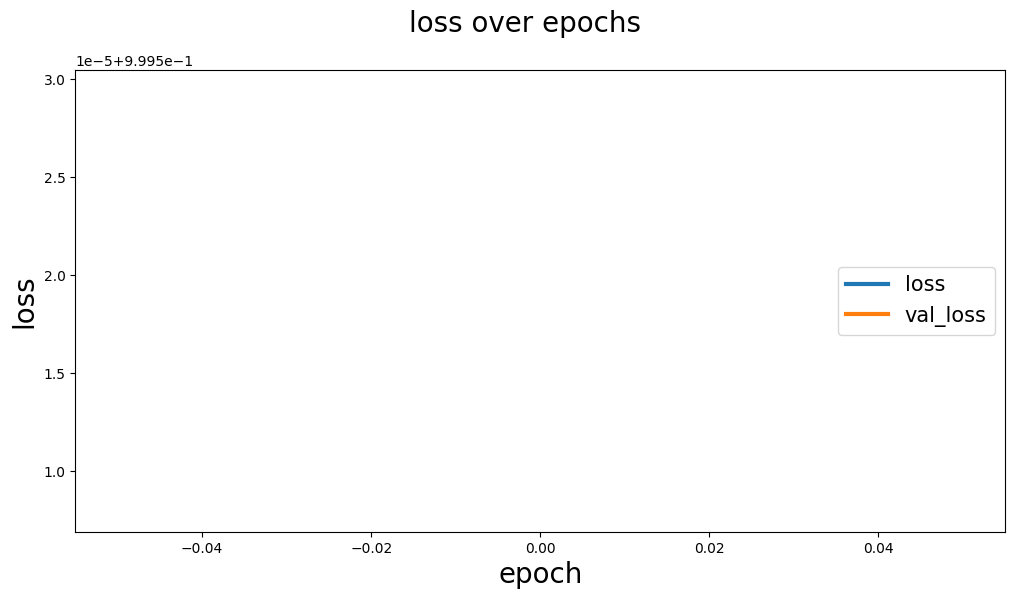

In [18]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [19]:
y_pred = model.predict(X_test)

4/4 [==============================] - 76s 17s/step


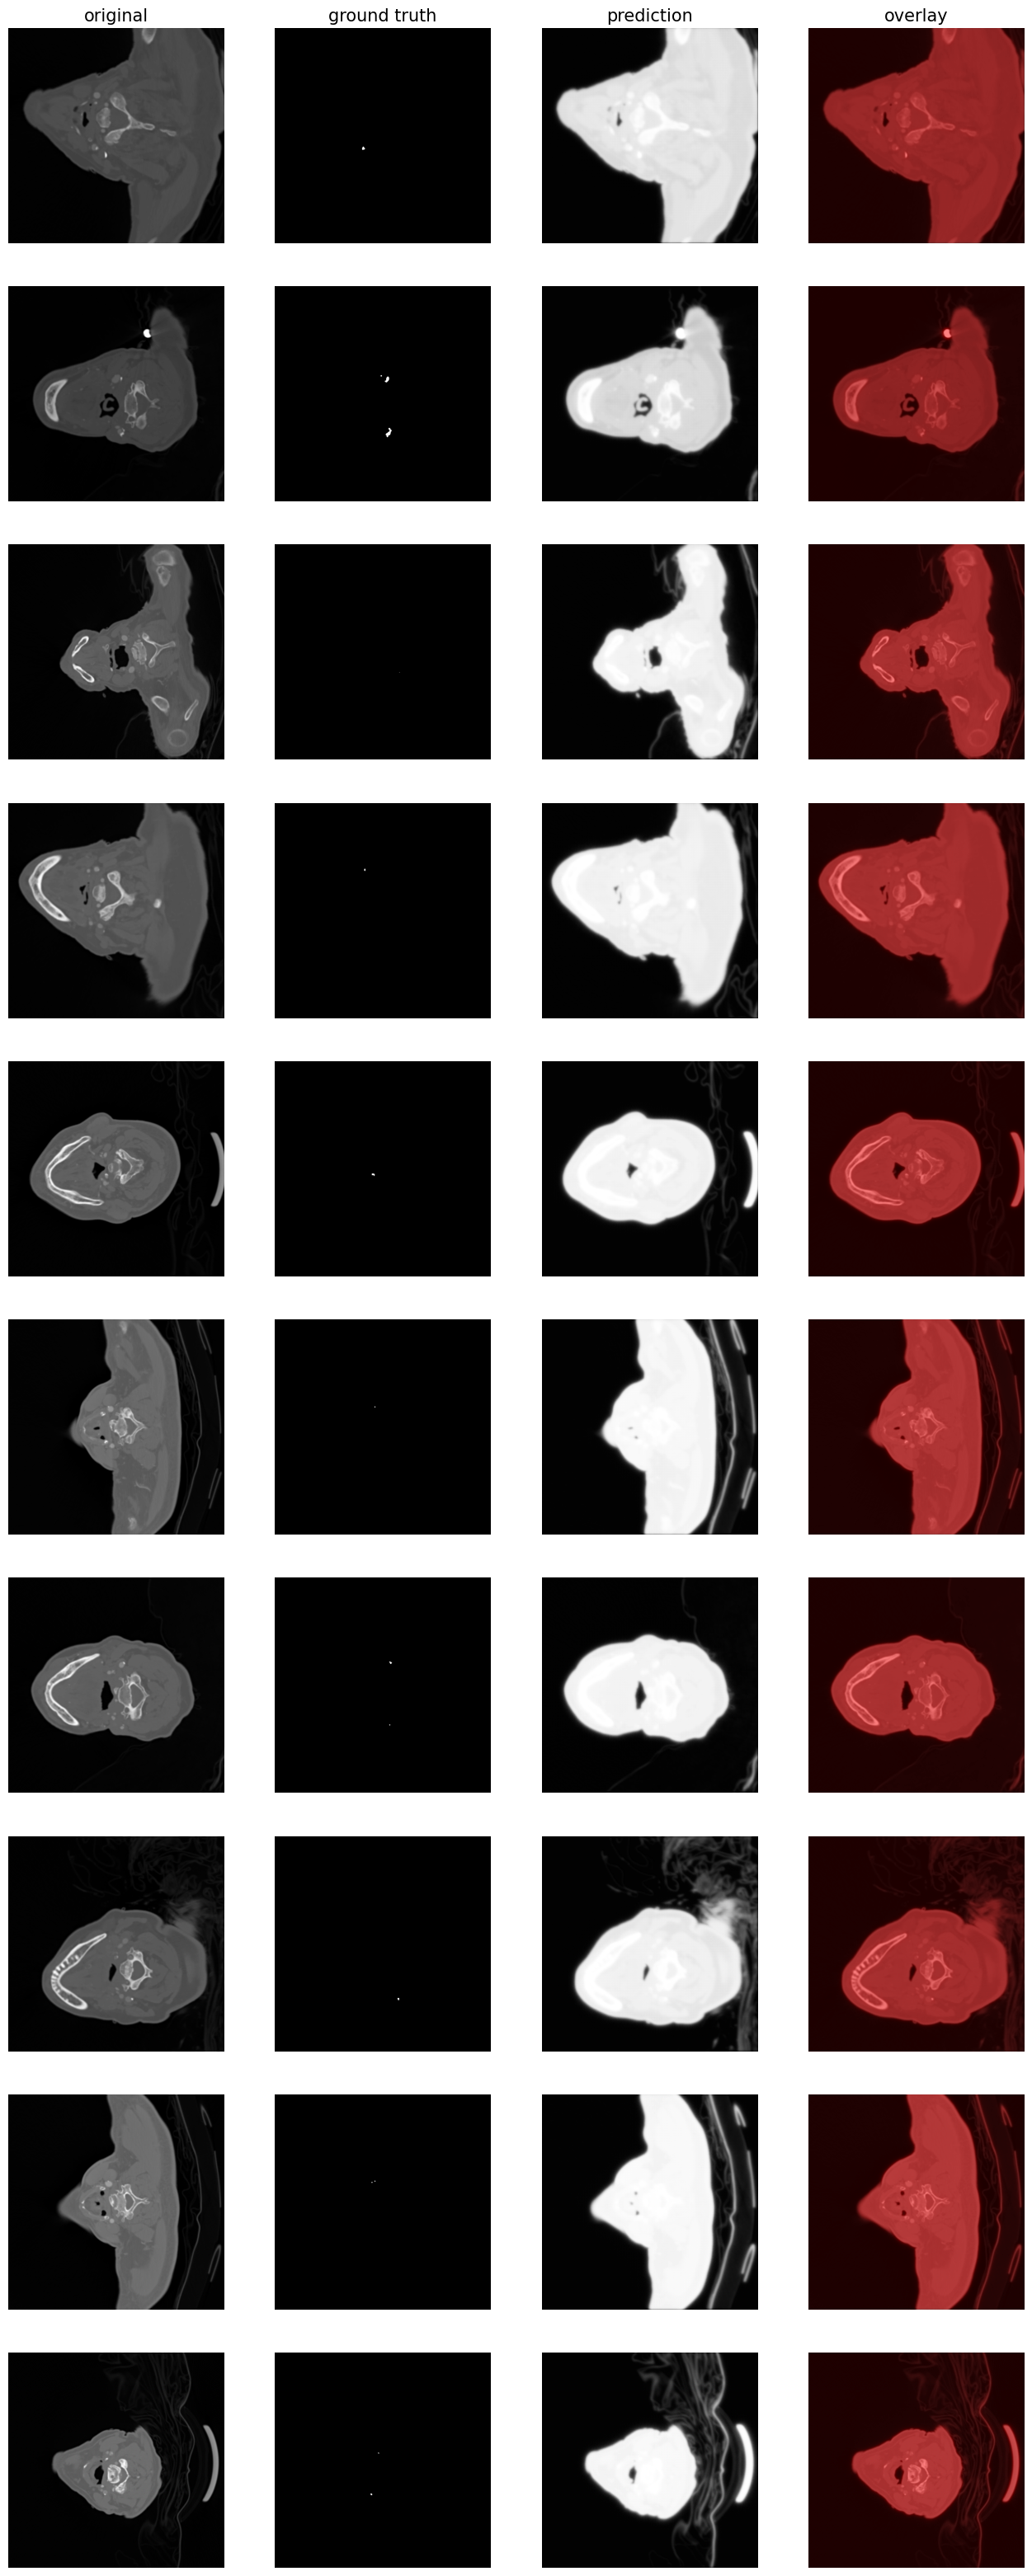

In [20]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=10)

In [21]:
loss, iou, iou_thresholded = model.evaluate(X_test, y_test)

4/4 [==============================] - 77s 18s/step - loss: 0.9995 - iou: 3.3052e-04 - iou_thresholded: 4.6850e-04
